## Delays and Filters

Today, we are going to implement a delay effect in Python and review filters.

In [1]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import sawtooth, square, butter, filtfilt
import matplotlib.pyplot as plt
from IPython.display import Audio, Image

## Delay

The simplest delay function will create a copy of the input, add some silence to the beginning of the copy, and combine it with the original input. 

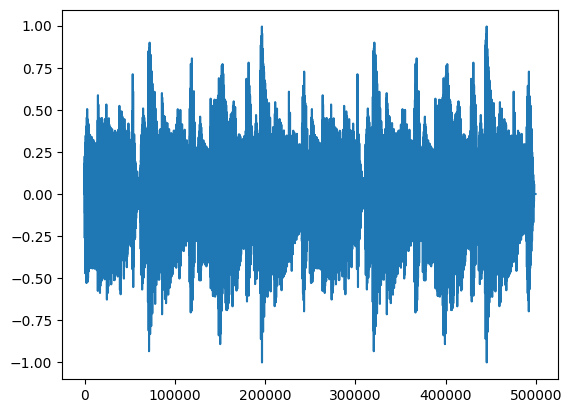

In [2]:
fs, x = read('../audio/AcousticGuitar.wav')
#normalize -1 between 1
data = x / abs(x).max()
plt.plot(data)


We will copy our original signal and then zero-pad to add delay. We have to zero-pad both the original and delayed signal so they are the same length.

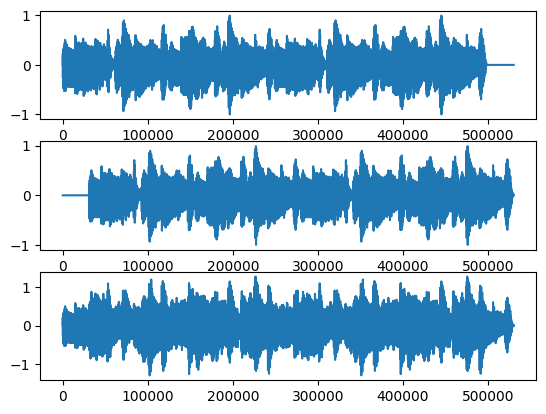

In [3]:
copy = data.copy()
offset = 700 #ms
offset_samples = int(fs/1000*offset)
pad = np.zeros(offset_samples)
orig = np.concatenate([data, pad])
delay = np.concatenate([pad, copy])
new_s = orig + delay

plt.subplot(3, 1, 1)
plt.plot(orig)
plt.subplot(3, 1, 2)
plt.plot(delay)
plt.subplot(3, 1, 3)
plt.plot(new_s)

In [5]:
Audio(new_s, rate=fs)

We can control the effect by scaling the delay signal before adding it.

In [ ]:
delay2 = delay * 0.5
new_s2 = orig+delay2
Audio(new_s2, rate=fs)

And we can keep adding to the effect by repeating the delay. This turns into a more continuous echo effect.

In [7]:
copy = data.copy()
offset = 1000 #ms
offset_samples = int(fs/1000*offset)
pad = np.zeros(offset_samples)
orig = np.concatenate([data, pad, pad, pad])
delay1 = np.concatenate([pad, copy, pad, pad])
delay2 = np.concatenate([pad, pad, copy, pad])
delay3 = np.concatenate([pad, pad, pad, copy])

new_s = orig + (delay1 * 0.5) + (delay2 * 0.25) + (delay3 * 0.125)
Audio(new_s, rate=fs)


We can rewrite this to be iterative...

In [ ]:
repeats = 3
offset 1000 # ms
offset_samples = int(fs/1000*offset)
pad = np.zeros(offset_samples)
orig = np.concatenate([data, pad])
delay = 
for i in range(repeats + 1):
    pad_beg = np.zeros(int(fs/1000*offset*i))
    pad_end = np.zeros(int(fs/1000*offset*(repeats-i)))
    delay += np.concatenate([pad_beg, copy, pad_end])

Audio(delay, rate = fs)


And we can take advantage of numpy functions. This is equivalent to delaying a signal in a circular buffer which is an important concept for real-time audio (something we’ll talk about later).

In [9]:
a = np.arange(10)
a = np.roll(a,5)
a 

array([5, 6, 7, 8, 9, 0, 1, 2, 3, 4])

In [ ]:
repeats = 3
offsets = 1000
pad = np.zeros(int(fs/1000*offset))
delay = np.concatenate([copy, np.tile[pad, 3]])
Audio(delay, rate=fs)

## Filters
Let's review some theory and terminology related to filters.

#### Filters control frequency response
Rather than build every sound from scratch by adding partials at various amplitudes, one way of varying the timbre of the sound is to use filters to control the **frequency response** of the output signal relative to the input.

#### Magnitude spectrum and power spectrum (technically not the same thing)
From the amplitude spectrum one can derive the power spectrum. Power is defined as the square of the amplitude of a signal. Thus, power spectrum is the square of the amplitude spectrum. Displays of spectrum sometimes show power, rather than amplitude, because this correlates better with human perception.

#### Spectrum and timbre
Spectrum and timbre are related concepts, but they are not equivalent. Spectrum is a physical property that can be characterized as a distribution of energy as a function of frequency. Timbre is a term that refers to the perceptual *quality* of a sound and is frequently (incorrectly) used interchangably with instrumentation. (An equivalent analogy is frequency, which is an acoustic term, and pitch, which is an acoustic or perceptual term.

## Filters

The most common varieties of filters:

* low-pass: attenuates frequencies above a target frequency, referred to as the "cutoff" frequency (lets low frequencies "pass through")

* high-pass: attenuates frequencies below a target frequency, referred to as the "cutoff" frequency (lets high frequencies "pass through")

* band-pass: attenuates frequencies above or below the target frequency range (effectively a low-pass and high-pass filter operating simultaneously)

* band stop: (a.k.a. notch filter) blocks and rejects frequencies that lie between its two cut-off frequency points passes all frequencies outside this range.

* EQ: boost or cut frequencies according to "bands" of the entire spectrum (note: shelving is a type of EQ)

* shelving: boost or cut energy at the target frequency and all audio frequencies either above or below it


#### EQ, a special case

The process of equalization can be modeled as a process of *adding or subtracting* a filtered version of the signal from the signal. Adding the filtered version gives a boost to the frequencies selected by the filter, whereas subtracting the filtered output reduces the frequency component amplitudes in the filter’s frequency range. 



#### Filter shape: 
Real filters do not suddenly stop passing signal components at a given frequency. Instead, there is a transition from passing the signal components to attenuating them. The cutoff frequency of a filter is usually expressed as the point at which it is attenuating the signal by 3 dB relative to the pass-band. Thus if a filter’s cutoff is set to a given frequency, there will be a region within the pass-band that affects the amplitude of the frequency components of the signal. This region can extend as far as an octave away from the cutoff point. Therefore, in practice, the filter’s cutoff frequency is commonly set *beyond* the "ideal" cutoff frequency. This is especially true when trying to minimize timbral change of a signal due to change in frequency content caused by the filter’s transition region.

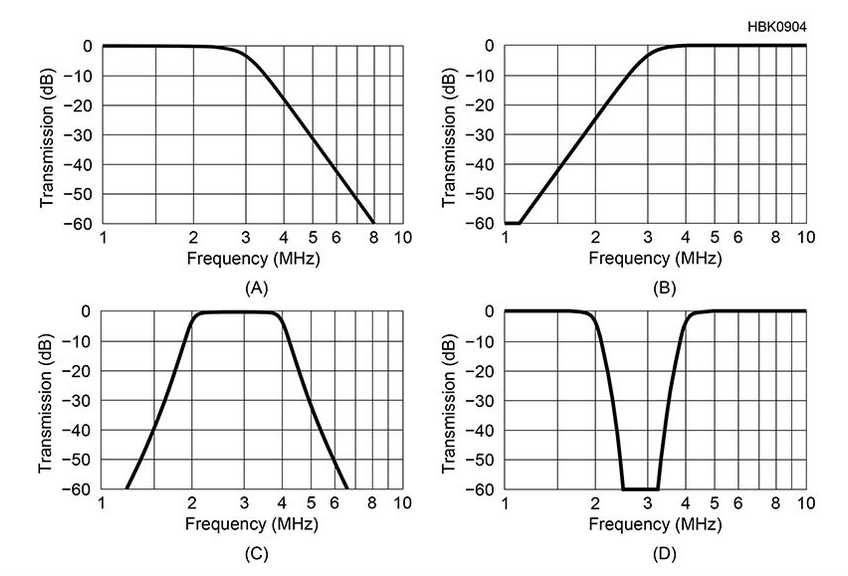

In [10]:
Image('../images/filtertypes.png')

As we discussed in Audio Tech I, filter design is not trivial and requires a lot of math. So, for this class, we are going to use functions from SciPy to help us build our filters.

We will be making use of a filter in the scipy package: `scipy.signal.butter` 

A Butterworth filter is a common type of signal processing filter designed to have a frequency response as flat as possible in the passband. It is therefore also referred to as a maximally flat magnitude filter.

It has an amplitude response of:

$\lvert mag \lvert = \frac{1}{\sqrt{1+\frac{\omega}{\omega_c}} ^{2n}}$

where $\omega_c$ is the cutoff frequency, and $n$ refers to the filter *order* (see graph below).

As the order of the filter increases, both the slope of the attenuation as a function of frequency and the sharpness of the cutoff increase; this reduces the *transition region* effects but, unfortunately, increases the time domain effects like ringing and overshoot.

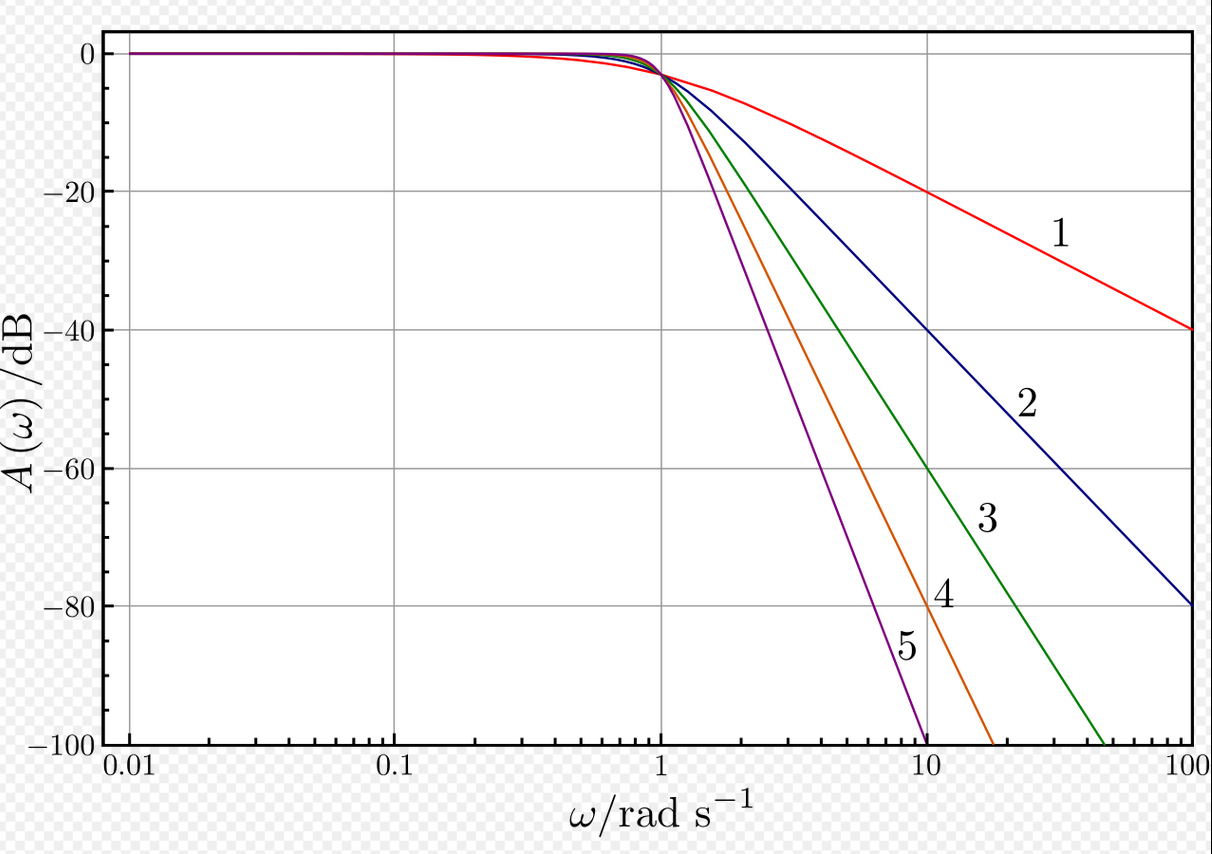

In [11]:
Image('../images/butterworth.png', width=700)

Butter returns our filter coefficients given the filter order and type.

We can pass those coefficients to filtfilt to actually filter our signal.

Let's start with a noisy signal.

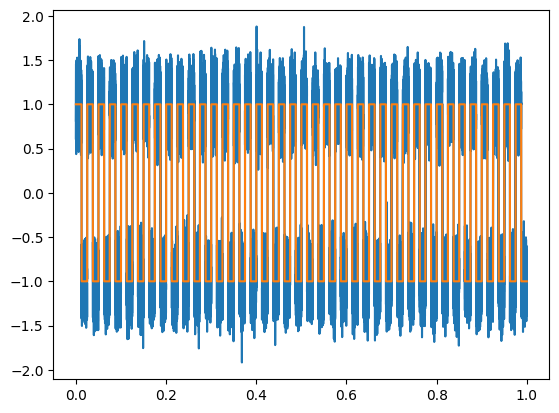

In [14]:
np.random.seed(60) #repeated result
f0 = 40 
fs = 44100
t = np.arange(0, 1, 1/fs)
signal = square(2*np.pi*f0*t)
noise = 0.2 * np.random.randn(signal.size)

plt.plot(t, signal+noise, t, signal)
Audio(signal+noise, rate=fs)



Here is the magnitude spectrum for the noise and signal separately. Notice that noise has a flat spectral shape. The difference between the signal and the noise is easier to see if you use a log scale:

In [ ]:
plt.figure(figsize=(8,4))
N=44100
plt.magnitude_spectrum(signal, N, scale='dB')
plt.magnitude_spectrum(noise, N, )

Now let's generate coefficients and filter our signal.

In [ ]:
cutoff = 500
order = 5

(b, a) = butter

It is easy to switch this to a highpass filter by changing the btype, but for bandpass or bandstop, you need to input 2 cutoffs.

In [16]:
cutoff = [500, 1000]
order = 5

(b, a) = butter(order, cutoff, btype = 'highpass', fs=fs)
y = filtfilt(b, a, (signal+noise))


ValueError: Must specify a single critical frequency Wn for lowpass or highpass filter

In [17]:
plt.figure(figsize=(8,4))
N=44100
plt.magnitude_spectrum(y, N)
plt.xlim(0, 3000)

NameError: name 'y' is not defined

<Figure size 800x400 with 0 Axes>

## Comb Filters

Bringing it back to delays, recall that filters are just delayed and scaled versions of a signal added to itself. Though we aren't building complex, high performing filters ourselves, we can build comb filters from scratch to illustrate the difference between FIR and IIR as well as the effect of delaying and scaling a signal. The comb filter implementation may lead you to chorus, flanger, and reverberator implementations as well.

We can write the difference equation of a delay as

$$y[n] = x[n] + g * x[n-D]$$

If you recall, that is the difference equation for a feedforward comb filter. This is an FIR (finite impulse response filter). We know the filter response to an impulse will diminish over a finite period of time.


<img src="https://ccrma.stanford.edu/~jos/pasp/img76_3x.png" alt="Image of feedfoward comb filter block diagram" width="500" />

Let's build again our filter (delay) again in Python but focus on implementing the difference equation.

(array([0.0260691 , 0.01207772, 0.0057553 , ..., 0.02237232, 0.0096484 ,
        0.00602928]),
 array([0.0000e+00, 2.0000e+00, 4.0000e+00, ..., 2.2046e+04, 2.2048e+04,
        2.2050e+04]),
 <matplotlib.lines.Line2D at 0x1af54045900>)

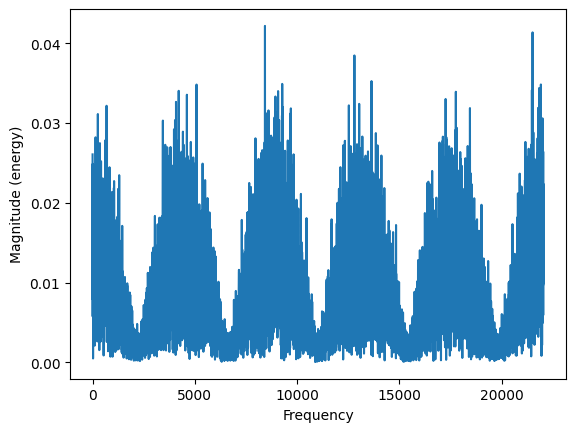

In [18]:
fs = 44100
dur = 0.5
x = np.random.normal(0, 1, int(fs*dur))

# delay_time = 0.2
# delay_in_samples = int(0.2 * fs)
delay_in_samples = 10
gain = .8

y = np.zeros_like(x) # this creates an array of zeros based on the size of the input array

for n in range(len(x)):
    y[n] = x[n]
    if n - delay_in_samples >= 0:
        y[n] += gain * x[n - delay_in_samples]

plt.magnitude_spectrum(y, Fs=fs)

A feedforward comb filter creates evenly spaced notches based on the delay time. 

If a sinusoidal component of a sound is delayed by exactly one cycle (i.e., one period) or any whole number of cycles, and mixed with the original sound, that component will be reinforced; conversely, if a component is delayed by one-half period, it will be cancelled. The delay determines the spacing between the notches in the comb filter's frequency response. 

For example, a 100Hz tone has a periodicity of 100/sec (or 100 per 1000 ms) and therefore 1 full cycle in 10ms. A delay of 10ms will therefore create complete constructive interference at 100Hz. Accordingly, a 100Hz tone delayed (or phase-shifted) by half of that (5ms) will have the result of complete destructive interference (i.e., notch) at 100Hz (but complete constructive interference at 200Hz). We can convert from ms to samples depending on the sampling rate. Subsequent notches or peaks occur at integer multiples of this fundamental frequency.

(array([2.27610610e-09, 2.62453625e-09, 3.47039903e-09, ...,
        5.12990344e-13, 5.12943546e-13, 5.12976842e-13]),
 array([0.0000e+00, 2.0000e+00, 4.0000e+00, ..., 2.2046e+04, 2.2048e+04,
        2.2050e+04]),
 <matplotlib.lines.Line2D at 0x1af54e05e10>)

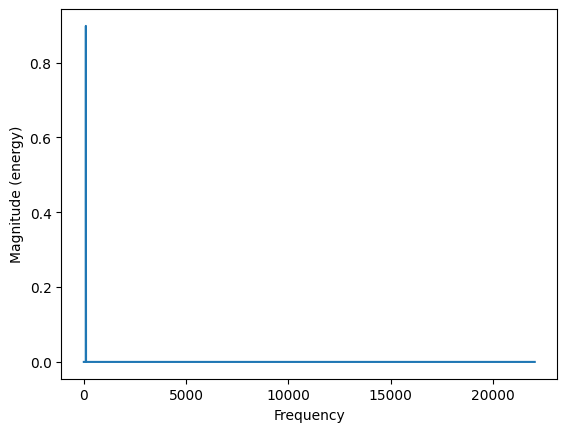

In [19]:
fs = 44100
dur = 0.5
x = np.sin(2*np.pi * 100 * np.arange(0, dur, 1/fs))

delay_time = 0.2
delay_in_samples = int(0.2 * fs)
delay_in_samples = 10
gain = .8

y = np.zeros_like(x) # this creates an array of zeros based on the size of the input array

for n in range(len(x)):
    y[n] = x[n]
    if n - delay_in_samples >= 0:
        y[n] += gain * x[n - delay_in_samples]

plt.magnitude_spectrum(y, Fs=fs)

The inverse of the delay time (in seconds) gives us the fundamental of the delay. So, there will be peaks at multiples of 1/delay time.

If our delay time is 2 ms at a sampling rate of 44100 Hz, what is the length of the delay and where are our peaks?

In [20]:
del_sec = 2/1000
del_samp = int(del_sec * 44100)
peak_freq = 1 / del_sec

print(del_samp, peak_freq)

88 500.0


So if we adjust the delay time, we change the width of the frequency "comb" and if we adjust the gain we control the amount the combs are applied.

If we have a positive gain (addition), notches will occur at multiples of the frequency 0.5/delay time. If we have a negative gain (subtraction), notches occur at mutliples of the frequency 1/delay time.

In [ ]:
fs = 44100
dur = 0.5
x = np.random.normal(0, 1, int(fs*dur))

# delay_time = 0.2
# delay_in_samples = int(0.2 * fs)
delay_in_samples = 10
gain = .8

y = np.zeros_like(x) # this creates an array of zeros based on the size of the input array

for n in range(len(x)):
    y[n] = x[n]
    if n - delay_in_samples >= 0:
        y[n] += gain * x[n - delay_in_samples]

plt.magnitude_spectrum(y, Fs=fs)
plt.xlim([0, 2000])

We can also implement a feedback comb filter in Python. 
Here is the difference equation for a FBCF.
$$y[n] = x[n] + g * y[n-D]$$

Notice that this is an IIR filter (infinite impulse response). An impulse sent into the filter may not diminish over a fixed amount of time because of the feedback property. The output depends on both the input and the output - feeding into itself.

<img src="https://ccrma.stanford.edu/~jos/pasp/img78_3x.png" alt="Image of feedback comb filter block diagram" width="500" />

In [ ]:
z

Notice that the peaks are at the same location, but much sharper or more resonant.

Remember an advantage to IIR over FIR filters is they are more efficient and can give sharper filters even at lower order. On the flip side, if the gain factor, g, goes above 1 for an IIR filter it will become unstable and could "blow up", whereas an FIR filter will always remain stable.

Before we move on, let's take a look at sending an impulse through both filters.

In [ ]:


plt.plot(freqs_FIR, 20*np.log10(np.abs(H_FIR) + 1e-12), label="FIR")
plt.plot(freqs_IIR, 20*np.log10(np.abs(H_IIR) + 1e-12), label="IIR")
plt.legend()
plt.xlim([0, 1000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()
